Reference:

https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools  
https://www.kaggle.com/ryches/turbo-charging-andrew-s-pytorch

In [1]:
!cat /proc/driver/nvidia/gpus/0000:00:04.0/information

Model: 		 Tesla K80
IRQ:   		 35
GPU UUID: 	 GPU-96c347ad-b7a0-bef2-3d07-3168b8783eba
Video BIOS: 	 80.21.25.00.02
Bus Type: 	 PCI
DMA Size: 	 40 bits
DMA Mask: 	 0xffffffffff
Bus Location: 	 0000:00:04.0
Device Minor: 	 0
Blacklisted:	 No


In [2]:
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install torch==1.2.0
!pip install -q albumentations==0.3.3
!pip install -q segmentation-models-pytorch==0.0.3

     |████████████████████████████████| 92kB 2.4MB/s 
     |████████████████████████████████| 634kB 8.2MB/s 
     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 61kB 3.4MB/s 


## Importing and parameters

In [0]:
import os, gc, time, json, copy
import pickle, random, itertools, collections
from tqdm import tqdm, tqdm_notebook
from functools import partial

import numpy as np
import pandas as pd
from PIL import Image
import cv2

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR

import albumentations as albu
from albumentations import pytorch as AT
import segmentation_models_pytorch as smp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 2019

label_classes = ["Fish", "Flower", "Gravel", "Sugar"]

path = '/content/'
img_paths = '/content/'
# model0_path = '../input/cloud-im-small/'
# model1_path = '../input/cld-rn50-unet-1/'
# model2_path = '../input/cld-rn50-unet-2/'
# model3_path = '../input/cld-rn50-unet-3/'
# model4_path = '../input/cld-rn50-unet-4/'
# model_paths = [model0_path, model1_path, model2_path, model3_path, model4_path]
# model0_path = '../input/cloud-im-small/'
# model1_path = '../input/cloud-ckpt-rn50-0/'
# model2_path = '../input/cld-rn50-unet-0-ladam/'
# model3_path = '../input/cld-rn50-unet-0-lalamb/'
# model_paths = [model0_path, model1_path, model2_path, model3_path]
model_un_0 = '/content/cloud-im-small/'
model_un_1 = '/content/cld-rn50-unet-0-ladam/'
model_un_4 = '/content/cld-rn50-unet-0-lalamb/'
model_fpn_0 = '/content/cld-rn50-fpn-0/'
model_fpn_2 = '/content/cld-rn50-fpn-2/'
model_fpn_4 = '/content/cld-rn50-fpn-4/'
un_paths = [model_un_0, model_un_1, model_un_4]
fpn_paths = [model_fpn_0, model_fpn_2, model_fpn_4]

n_splits = 5
which_fold = 0  # should be int in [0, n_splits-1]

batch_size = 32

## Download the data

In [5]:
!ls

cld-rn50-fpn-0		cloud-im-small	       train.csv
cld-rn50-fpn-2		drive		       train_images_525
cld-rn50-fpn-4		sample_data	       train_masks_525
cld-rn50-unet-0-ladam	sample_submission.csv
cld-rn50-unet-0-lalamb	test_images_525


In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [9]:
!kaggle competitions download -c understanding_cloud_organization -f train.csv
!kaggle competitions download -c understanding_cloud_organization -f sample_submission.csv
!unzip train.csv.zip
!rm train.csv.zip

 89% 48.0M/54.2M [00:00<00:00, 107MB/s] 
100% 54.2M/54.2M [00:00<00:00, 156MB/s]
  0% 0.00/321k [00:00<?, ?B/s]
100% 321k/321k [00:00<00:00, 48.6MB/s]
Archive:  train.csv.zip
  inflating: train.csv               


In [10]:
!kaggle datasets download -d ryches/understanding-clouds-resized
!unzip -q understanding-clouds-resized.zip
!rm understanding-clouds-resized.zip

100% 0.98G/0.98G [00:31<00:00, 36.7MB/s]
100% 0.98G/0.98G [00:32<00:00, 32.9MB/s]


In [11]:
len(os.listdir('train_images_525/train_images_525')), len(os.listdir('test_images_525/test_images_525'))

(5546, 3698)

In [0]:
!kaggle datasets download -d radream/cld-rn50-fpn-0
!unzip -q cld-rn50-fpn-0.zip -d cld-rn50-fpn-0
!rm cld-rn50-fpn-0.zip

!kaggle datasets download -d radream/cld-rn50-fpn-2
!unzip -q cld-rn50-fpn-2.zip -d cld-rn50-fpn-2
!rm cld-rn50-fpn-2.zip

!kaggle datasets download -d radream/cld-rn50-fpn-4
!unzip -q cld-rn50-fpn-4.zip -d cld-rn50-fpn-4
!rm cld-rn50-fpn-4.zip

!kaggle datasets download -d radream/cloud-im-small
!unzip -q cloud-im-small.zip -d cloud-im-small
!rm cloud-im-small.zip

!kaggle datasets download -d radream/cld-rn50-unet-0-lalamb
!unzip -q cld-rn50-unet-0-lalamb.zip -d cld-rn50-unet-0-lalamb
!rm cld-rn50-unet-0-lalamb.zip

!kaggle datasets download -d radream/cld-rn50-unet-0-ladam
!unzip -q cld-rn50-unet-0-ladam.zip -d cld-rn50-unet-0-ladam
!rm cld-rn50-unet-0-ladam.zip

In [0]:
if not os.path.exists(path+'train'): os.mkdir(path+'train')
if not os.path.exists(path+'test'): os.mkdir(path+'test')

In [0]:
!kaggle competitions download -c understanding_cloud_organization -f train_images.zip
!unzip train_images.zip -d train

In [0]:
!kaggle competitions download -c understanding_cloud_organization -f test_images.zip
!unzip test_images.zip -d test

In [0]:
!rm train_images.zip test_images.zip

In [0]:
len(os.listdir('train')), len(os.listdir('test'))

(5546, 3698)

## Helper functions and classes

In [0]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def seed_torch(seed=SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

def get_img(x, folder: str='train_images_525/train_images_525'):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{img_paths}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def rle_decode(mask_rle: str = '', shape: tuple = (1400, 2100)):
    """
    Decode rle encoded mask.
    
    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def make_mask(image_name: str='img.jpg', shape: tuple=(350, 525)):
    "Create mask (ndarray, values between 0-1) based on image name and shape."
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    for classidx, classid in enumerate(label_classes):
        mask = cv2.imread(f"{img_paths}/train_masks_525/train_masks_525/" + classid + image_name)
        if mask is None:
            continue
        if mask[:,:,0].shape != (350,525):
            mask = cv2.resize(mask, (525,350))
        masks[:, :, classidx] = mask[:,:,0]
    masks = masks / 255
    return masks

def mask2rle(img):
    """
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot images and masks.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - original ones: If given, show them all
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].axis('off')
        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].axis('off')
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f'Mask {class_dict[i]}', fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].axis('off')
        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
                
        for i in range(4):
            ax[0, i + 1].axis('off')
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)
        
        ax[1, 0].axis('off')
        ax[1, 0].imshow(image)
        ax[1, 0].set_title('Transformed image', fontsize=fontsize)        
        
        for i in range(4):
            ax[1, i + 1].axis('off')
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(f'Transformed mask {class_dict[i]}', fontsize=fontsize)
            
            
def visualize_with_raw(image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None):
    """
    Plot images and masks.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - original ones / raw ones: If given, show them all
    """
    fontsize = 14
    class_dict = {0: 'Fish', 1: 'Flower', 2: 'Gravel', 3: 'Sugar'}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].axis('off')
    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].axis('off')
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f'Original mask {class_dict[i]}', fontsize=fontsize)

    ax[1, 0].axis('off')
    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title('Raw image', fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].axis('off')
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f'Raw predicted mask {class_dict[i]}', fontsize=fontsize)
        
    ax[2, 0].axis('off')
    ax[2, 0].imshow(image)
    ax[2, 0].set_title('Transformed image', fontsize=fontsize)

    for i in range(4):
        ax[2, i + 1].axis('off')
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(f'Predicted mask with processing {class_dict[i]}', fontsize=fontsize)
            
            
def plot_with_augmentation(image, mask, augment):
    """
    Plot images, masks and augmentation results.
    
    Input
    - image: ndarray image loaded from cv2
    - mask: ndarray output from make_mask
    - augment: transformation from albumentations
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented['image']
    mask_flipped = augmented['mask']
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)


def post_process(probability, threshold, min_size):
    """
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    
    Input
    - probability: predicted probability mask, ndarray (350, 525)
    - threshold: value to binarize probability mask
    - min_size: ??
    """
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(256, 384)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def compute_dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2. * intersection.sum() / (img1.sum() + img2.sum())

## Data overview

Let's have a look at the data first.
We have folders with train and test images, file with train image ids and masks and sample submission.

In [0]:
train = pd.read_csv(f'{path}/train.csv')
sub = pd.read_csv(f'{path}/sample_submission.csv')

In [0]:
n_train = len(os.listdir(f'{img_paths}/train_images_525/train_images_525'))
n_test = len(os.listdir(f'{img_paths}/test_images_525/test_images_525'))
print(f'There are {n_train} images in train dataset')
print(f'There are {n_test} images in test dataset')

There are 5546 images in train dataset
There are 3698 images in test dataset


## Preparing data for modelling

At first, let's create a list of unique image ids and the count of masks for images. This will allow us to make a stratified split based on this count.

In [0]:
def train_val_split(id_mask_count, n_splits=None, which_fold=None):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    cv_indices = [(tr_idx, val_idx) for tr_idx, val_idx in kf.split(id_mask_count['img_id'], id_mask_count['count'])]
    if which_fold is not None:
        return cv_indices[which_fold]
    return cv_indices

In [0]:
id_mask_count = (train.loc[~train['EncodedPixels'].isnull(), 'Image_Label']
                    .apply(lambda x: x.split('_')[0])
                    .value_counts()
                    .reset_index()
                    .rename(columns={'index': 'img_id', 'Image_Label': 'count'}))

trn_idx, val_idx = train_val_split(id_mask_count, n_splits, which_fold)
train_ids, valid_ids = id_mask_count['img_id'].values[trn_idx], id_mask_count['img_id'].values[val_idx]
test_ids = sub['Image_Label'].apply(lambda x: x.split('_')[0]).drop_duplicates().values

In [19]:
len(train_ids), len(valid_ids)

(4435, 1111)

In [20]:
id_mask_count

,img_id,count
0,ad07d6c.jpg,4
1,964d4a6.jpg,4
2,d8cdb15.jpg,4
3,6255e8f.jpg,4
4,36f9bee.jpg,4
...,...,...
5541,1f9dc0a.jpg,1
5542,9ed4ba4.jpg,1
5543,b9145ee.jpg,1
5544,d3dfa34.jpg,1


In [21]:
id_mask_count['count'].value_counts()

2    2372
3    1560
1    1348
4     266
Name: count, dtype: int64

There are a lot of empty masks. In fact only 266 images have all four masks. It is important to remember this.

## Setting up data loader, model, solver

In [0]:
class CloudDataset(Dataset):
    def __init__(self, dataset_type: str='train', img_ids: np.array=None,
                 transforms=albu.Compose([albu.HorizontalFlip(), AT.ToTensor()]),
                 preprocessing=None, label_smooth=0):
        self.dataset_type = dataset_type
        if dataset_type != 'test':
            self.data_folder = f"{img_paths}/train_images_525/train_images_525"
        else:
            self.data_folder = f"{img_paths}/test_images_525/test_images_525"
        self.img_ids = img_ids
        self.transforms = transforms
        self.preprocessing = preprocessing
        self.label_smooth = label_smooth

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(image_name)
        img = cv2.imread(os.path.join(self.data_folder, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        if self.label_smooth > 0:
            mask = np.where(mask==1, 1-label_smooth, label_smooth).astype('float32')
        if self.preprocessing:
            preprocessed = self.preprocessing(image=img, mask=mask)
            img = preprocessed['image']
            mask = preprocessed['mask']
        return img, mask

    def __len__(self):
        return len(self.img_ids)

In [32]:
im = np.array(Image.open(path+'train_images_525/train_images_525/'+valid_ids[0]))
mask = make_mask(valid_ids[0])
im.shape, mask.shape

((350, 525, 3), (350, 525, 4))

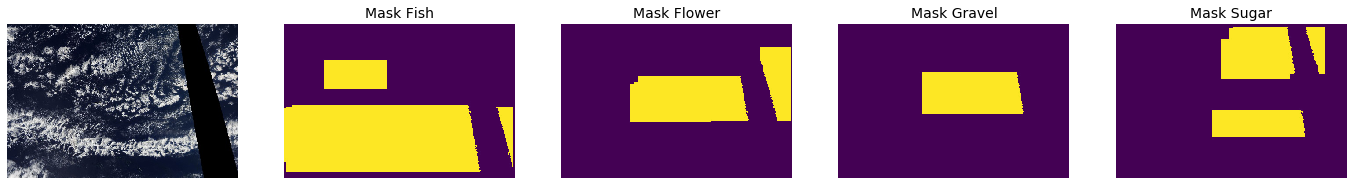

In [33]:
visualize(np.array(im), mask)

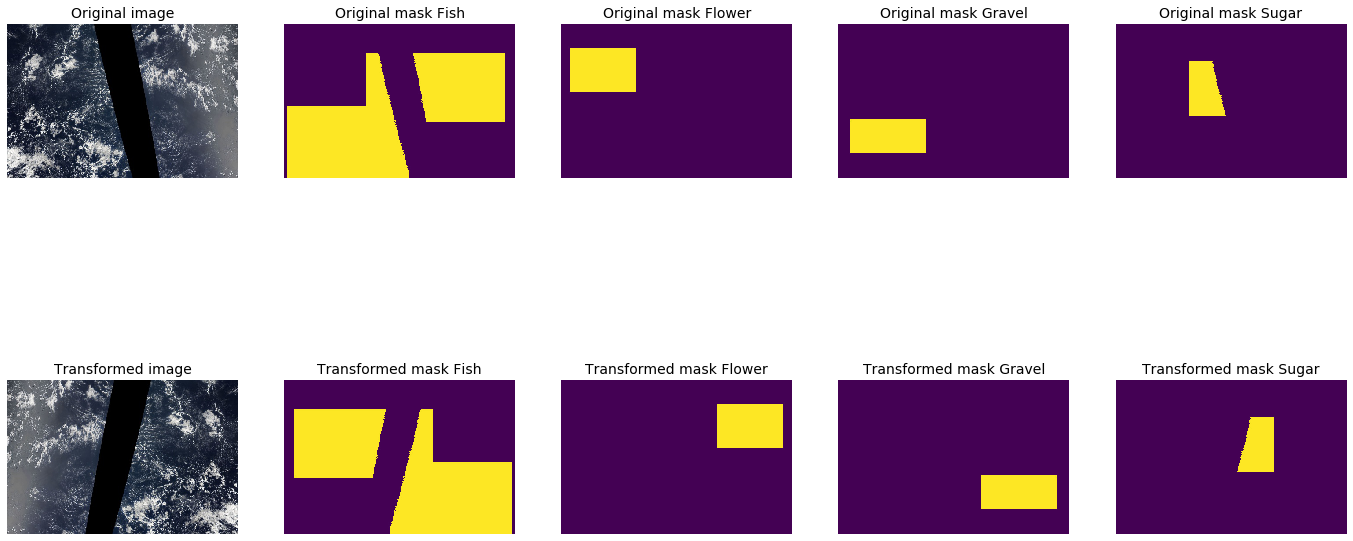

In [76]:
plot_with_augmentation(np.array(im), mask, albu.HorizontalFlip(p=1))

In [0]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = None
ACTIVATION = None

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER)

unet = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION
)
unet = unet.to(device)

fpn = smp.FPN(
    encoder_name='resnet34', 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=4, 
    activation=ACTIVATION
)
fpn = fpn.to(device)

In [12]:
print(str(torch.cuda.memory_allocated(device)/1e6 ) + 'M')
print(str(torch.cuda.memory_cached(device)/1e6 ) + 'M')
torch.cuda.empty_cache()

228.8384M
249.561088M


In [24]:
valid_dataset = CloudDataset(dataset_type='valid', img_ids=valid_ids[:6],
                             transforms=get_validation_augmentation(),
                             preprocessing=get_preprocessing(preprocessing_fn))

valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False,
                          num_workers=2, pin_memory=True)

# it = iter(valid_loader)
# ims, masks = next(it)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2567: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


In [14]:
test_dataset = CloudDataset(dataset_type='test', img_ids=test_ids,
                             transforms=get_validation_augmentation(),
                             preprocessing=get_preprocessing(preprocessing_fn))

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2567: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  warnings.warn('Using lambda is incompatible with multiprocessing. '


## Model inference

In [0]:
def get_preds(loader, model, dataset_type='test'):
    """
    Inference for testset.

    :param loader: DataLoader for testing data
    :param model: model
    :param dataset_type: dataset type

    :return: list of batch predictions
    """
    assert dataset_type in ('val', 'test')
    model.eval()  # eval mode disables dropout

    if dataset_type=='val':
        label_masks = []
    predictions = []
    with torch.no_grad():
        # Batches
        for images, masks in tqdm_notebook(loader):
            if dataset_type=='val':
                for m in masks.view(-1, 256, 384).numpy():
#                 for m in masks.view(-1, 320, 640).numpy():
                    m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                    label_masks.append(m)
            
            # Move to default device
            images = images.to(device)  # (N, 3, 320, 640)
            
            # Forward prop.
            pred_scores = model(images)  # (N, 4, 320, 640)
            pred_scores = pred_scores.view(-1, 256, 384)
#             pred_scores = pred_scores.view(-1, 320, 640)  # (N*4, 320, 640)
            
            # Resize to required size
            for m in torch.sigmoid(pred_scores).cpu().numpy():
                m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                predictions.append(m)
    torch.cuda.empty_cache()

    if dataset_type=='val':
        return predictions, label_masks
    return predictions

In [0]:
class Rot90(object):
    """rotate batch of images by 90 degrees k times"""
    def __init__(self, k=1):
        self.k = k
    def transform(self, x):
        return torch.rot90(x, self.k, (2, 3))
    def inverse(self, x):
        return torch.rot90(x, -self.k, (2, 3))

class Hflip(object):
    """flip batch of images horizontally"""
    def transform(self, x):
        return x.flip(3)
    def inverse(self, x):
        return x.flip(3)

class Vflip(object):
    """flip batch of images vertically"""
    def transform(self, x):
        return x.flip(2)
    def inverse(self, x):
        return x.flip(2)

def TTA(loader, model, dataset_type='test', beta=0.4):
    """
    Inference for testset with test-time augmentation (TTA).

    :param loader: DataLoader for testing data
    :param model: model
    :param dataset_type: dataset type
    :param beta: ratio of prediction from original dataset in final results

    :return: list of batch predictions
    """
    assert dataset_type in ('val', 'test')
    model.eval()  # eval mode disables dropout
    tsfms = [Vflip(), Hflip(), Rot90(k=1), Rot90(k=2), Rot90(k=3)]

    if dataset_type=='val':
        label_masks = []
    predictions = []
    with torch.no_grad():
        # Batches
        for images, masks in tqdm_notebook(loader):
            if dataset_type=='val':
                for m in masks.view(-1, 256, 384).numpy():
#                 for m in masks.view(-1, 320, 640).numpy():
                    m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                    label_masks.append(m)
            
            # Move to default device
            images = images.to(device)  # (N, 3, 320, 640)
            
            # Forward prop.
            pred_scores = beta * model(images)  # (N, 4, 320, 640)
            
            # TTA
            for tsfm in tsfms:
                pred_scores += (1-beta) * tsfm.inverse(model(tsfm.transform(images))) / len(tsfms)
            
            # Resize to required size
            pred_scores = pred_scores.view(-1, 256, 384)
#             pred_scores = pred_scores.view(-1, 320, 640)  # (N*4, 320, 640)
            for m in torch.sigmoid(pred_scores).cpu().numpy():
                m = cv2.resize(m, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                predictions.append(m)
    torch.cuda.empty_cache()

    if dataset_type=='val':
        return predictions, label_masks
    return predictions

In [0]:
def TTA_inference(loader, class_params, beta=0.4, output_type='run_length'):
    """
    Inference for testset with test-time augmentation (TTA).

    :param loader: DataLoader for testing data
    :param model: model
    :param dataset_type: dataset type
    :param beta: ratio of prediction from original dataset in final results

    :return: list of batch predictions
    """
    tsfms = [Vflip(), Hflip(), Rot90(k=1), Rot90(k=2), Rot90(k=3)]

    if output_type=='run_length':
        encoded_pixels = []
    else:
        pred_masks = []
        predictions = []
    image_id = 0
    
    with torch.no_grad():
        # Batches
        for images, masks in tqdm_notebook(loader):
            
            # Move to default device
            images = images.to(device)  # (N, 3, 320, 640)
            
            # Model ensembles
            pred_scores = 0
            for mp in un_paths:
                unet.load_state_dict(torch.load(mp+'best_model_optim.pt')['model'])
                unet.eval()
                
                # Forward prop.
                pred_scores += 0.25 * beta * unet(images) / len(un_paths)  # (N, 4, 320, 640)

                # TTA
                for tsfm in tsfms:
                    pred_scores += 0.25 * (1-beta) * tsfm.inverse(unet(tsfm.transform(images))) / len(tsfms) / len(un_paths)
                
                torch.cuda.empty_cache()
            
            for mp in fpn_paths:
                fpn.load_state_dict(torch.load(mp+'best_model_optim.pt')['model'])
                fpn.eval()
                
                # Forward prop.
                pred_scores += 0.75 * beta * fpn(images) / len(fpn_paths)  # (N, 4, 320, 640)

                # TTA
                for tsfm in tsfms:
                    pred_scores += 0.75 * (1-beta) * tsfm.inverse(fpn(tsfm.transform(images))) / len(tsfms) / len(fpn_paths)
                
                torch.cuda.empty_cache()
            
            # Resize back and encode to rle
            pred_scores = pred_scores.view(-1, 256, 384)  # (N*4, 256, 384)
            for prob_mask in torch.sigmoid(pred_scores).cpu().numpy():
                prob_mask = cv2.resize(prob_mask, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
                pred, num_pred = post_process(prob_mask, *class_params[image_id%4])
                if num_pred == 0:
                    if output_type=='run_length':
                        encoded_pixels.append('')
                    else:
                        pred_masks.append(prob_mask)
                        predictions.append(np.zeros((350, 525)))
                else:
                    if output_type=='run_length':
                        r = mask2rle(pred)
                        encoded_pixels.append(r)
                    else:
                        pred_masks.append(prob_mask)
                        predictions.append(pred)
                image_id += 1
    
    torch.cuda.empty_cache()

    if output_type=='run_length':
        return encoded_pixels
    else:
        return pred_masks, predictions

In [0]:
# class_params = [(0.45, 22500), (0.3, 22500), (0.5, 15000), (0.4, 10000)]
# class_params = [(0.45, 22500), (0.5, 22500), (0.45, 22500), (0.4, 10000)]
# class_params = [(0.45, 22500), (0.45, 22500), (0.5, 15000), (0.4, 12500)]
# class_params = [(0.45, 22500), (0.45, 22500), (0.45, 22500), (0.45, 20000)]
# class_params = [(0.4, 25000), (0.2, 22500), (0.2, 22500), (0.5, 10000)]
# class_params = [(0.35, 22500), (0.35, 20000), (0.4, 25000), (0.4, 10000)]
# class_params = [(0.3, 15000), (0.5, 10000), (0.45, 20000), (0.35, 15000)]

# class_params = [(0.35, 25000), (0.35, 15000), (0.2, 22500), (0.4, 15000)]
# class_params = [(0.3, 20000), (0.55, 15000), (0.35, 15000), (0.25, 15000)]
class_params = [(0.35, 22500), (0.5, 15000), (0.45, 15000), (0.35, 15000)]

### Prediction from testset

In [45]:
# predictions = get_preds(test_loader, model) # list
# predictions = TTA(test_loader, model) # list
# encoded_pixels = TTA_inference(test_loader, class_params)
pred_masks_val, pred_val = TTA_inference(valid_loader, class_params, output_type='pred')

print(str(torch.cuda.memory_allocated(device)/1e6 ) + 'M')
print(str(torch.cuda.memory_cached(device)/1e6 ) + 'M')
torch.cuda.empty_cache()


228.8384M
270.532608M


In [0]:
ims = [np.array(Image.open(path+'train_images_525/train_images_525/'+valid_ids[i])) for i in range(6)]
masks = [make_mask(valid_ids[i]) for i in range(6)]

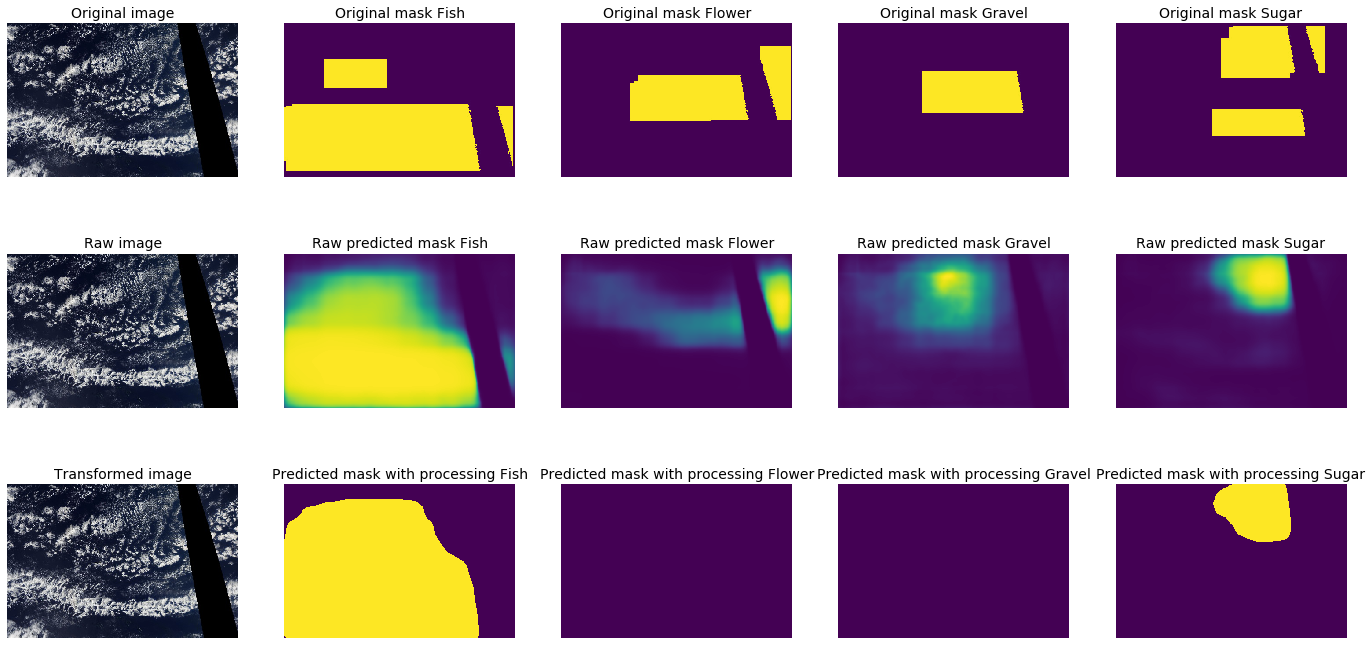

In [60]:
p_mask = np.stack([pred_val[i] for i in (0,1,2,3)]).transpose(1,2,0)
pr_mask = np.stack([pred_masks_val[i] for i in (0,1,2,3)]).transpose(1,2,0)

visualize_with_raw(image=ims[0], mask=p_mask,
                   original_image=ims[0], original_mask=masks[0],
                   raw_image=ims[0], raw_mask=pr_mask)

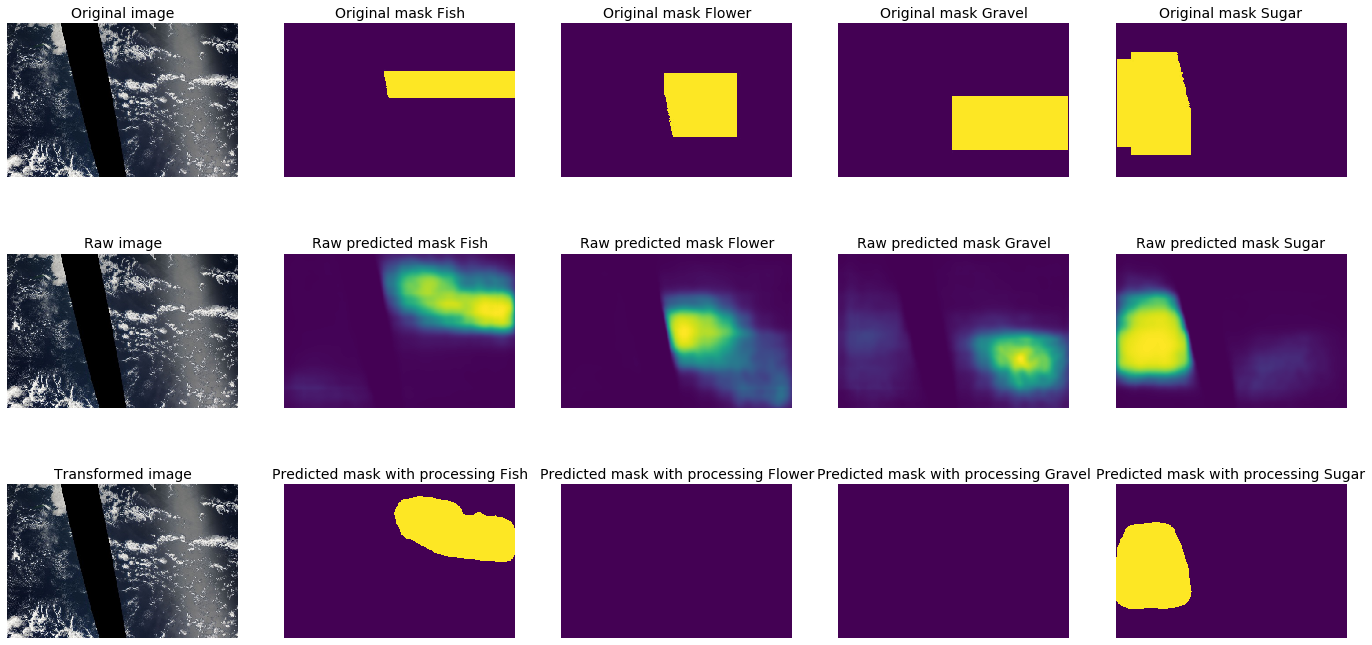

In [61]:
p_mask = np.stack([pred_val[i] for i in (4,5,6,7)]).transpose(1,2,0)
pr_mask = np.stack([pred_masks_val[i] for i in (4,5,6,7)]).transpose(1,2,0)

visualize_with_raw(image=ims[1], mask=p_mask,
                   original_image=ims[1], original_mask=masks[1],
                   raw_image=ims[1], raw_mask=pr_mask)

In [0]:
sub['EncodedPixels'] = encoded_pixels
sub.to_csv('submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)